In [1]:
import numpy as np
import pandas as pd 
import keras
from tensorflow.keras.utils import to_categorical
#Import Libraries before model creation
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
emotion_data = pd.read_csv('/content/drive/MyDrive/fer2013/fer2013.csv')
print('Dataset loaded successfully')

Dataset loaded successfully


In [3]:
emotion_data.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [4]:
emotion_data.tail()

emotion                                             pixels        Usage
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

In [5]:
emotion_data.head(10)

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...  Training
7        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...  Training
8        3  85 84 90 121 101 102 133 153 153 169 177 189 1...  Training
9        2  255 254 255 254 254 179 122 107 95 124 149 150...  Training

In [6]:
emotion_data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [7]:
data_train = emotion_data[emotion_data['Usage']== 'Training'].copy()
data_val = emotion_data[emotion_data['Usage']=='PublicTest'].copy()
data_test = emotion_data[emotion_data['Usage']=='PrivateTest'].copy()

In [8]:
print('Train shape: {}\nValidation shape: {}\nTest shape: {}'.format(data_train.shape,data_val.shape,data_test.shape))

Train shape: (28709, 3)
Validation shape: (3589, 3)
Test shape: (3589, 3)


In [9]:
num_classes = 7
epochs = 55
batch_size = 64
num_features = 32
width, height = 48,48

In [10]:
emotion_data.shape

(35887, 3)

In [11]:
emotion_data.describe()

emotion
count  35887.000000
mean       3.323265
std        1.873819
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        6.000000

In [12]:
emotion_data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


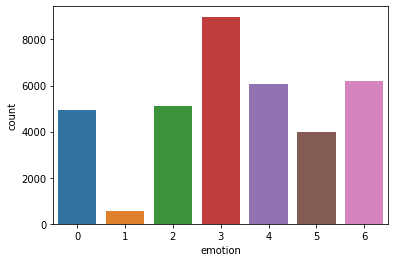

In [13]:
from matplotlib import pyplot
sns.countplot(emotion_data.emotion)
pyplot.show()

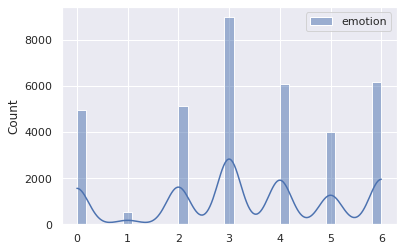

In [14]:
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)
sns.histplot(data= emotion_data,kde = True)

In [15]:
#Data Preprocessing
#Perform CRNO (CRNO stands for Convert,Reshape, Normalize, one-hot-encoding)
def CRNO(df,dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(),dtype='float32').reshape(-1,width,height,1)/255.0
    data_Y = to_categorical(df['emotion'],num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X,data_Y

In [16]:
train_X,train_Y = CRNO(data_train,'train')
val_X,val_Y = CRNO(data_val,'validation')
test_X,test_Y = CRNO(data_test,'test')

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
validation _X shape: {},  validation _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [23]:
model = Sequential()
#Module1 conv<<conv<<batchnorm<<relu<<maxpooling<<dropout
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same',data_format='channels_last',input_shape=(width, height, 1)))
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.1))
#Module2 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.1))
#Module3 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),padding='same'))
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.1))


#Module4 fc<<batchnorm<<fc<<batchnorm<<dropout<<softmax
model.add(Flatten())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes,activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_28 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_13 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 64)       

In [24]:
#Training the model
history = model.fit(train_X,train_Y,batch_size=batch_size,epochs=50,validation_data=(val_X,val_Y),shuffle=False)

Epoch 1/50
449/449 [==============================] - 87s 61ms/step - loss: 1.7886 - accuracy: 0.3229 - val_loss: 1.6140 - val_accuracy: 0.3603
Epoch 2/50
449/449 [==============================] - 27s 60ms/step - loss: 1.4352 - accuracy: 0.4564 - val_loss: 1.4438 - val_accuracy: 0.4492
Epoch 3/50
449/449 [==============================] - 27s 59ms/step - loss: 1.3207 - accuracy: 0.5014 - val_loss: 1.4436 - val_accuracy: 0.4486
Epoch 4/50
449/449 [==============================] - 27s 59ms/step - loss: 1.2514 - accuracy: 0.5298 - val_loss: 1.6600 - val_accuracy: 0.3937
Epoch 5/50
449/449 [==============================] - 27s 60ms/step - loss: 1.2048 - accuracy: 0.5461 - val_loss: 1.4214 - val_accuracy: 0.4656
Epoch 6/50
449/449 [==============================] - 27s 59ms/step - loss: 1.1729 - accuracy: 0.5607 - val_loss: 1.2925 - val_accuracy: 0.5138
Epoch 7/50
449/449 [==============================] - 27s 59ms/step - loss: 1.1402 - accuracy: 0.5730 - val_loss: 1.3908 - val_accuracy:

In [25]:
loss_and_metrics = model.evaluate(test_X,test_Y)
print(loss_and_metrics)

113/113 [==============================] - 2s 12ms/step - loss: 1.4085 - accuracy: 0.5678
[1.4085315465927124, 0.5678461790084839]


In [26]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.5678


In [27]:
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=test_true,predictions=test_pred)
cm

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[226,   8,  55,  18, 123,  10,  51],
       [ 13,  26,   9,   1,   5,   0,   1],
       [ 72,   6, 230,  25, 117,  34,  44],
       [ 35,   2,  46, 650,  75,  15,  56],
       [ 72,   5,  82,  28, 301,   9,  97],
       [ 18,   3,  56,  27,  20, 278,  14],
       [ 58,   2,  56,  39, 134,  10, 327]], dtype=int32)>

Text(66.5, 0.5, 'Truth')

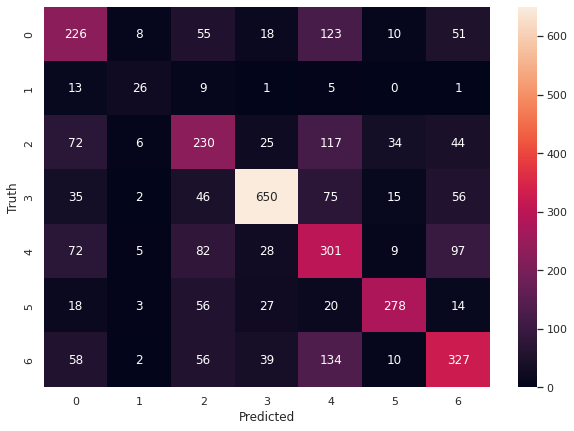

In [28]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
print("Classification Report: \n", classification_report(test_true, test_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.46      0.46      0.46       491
           1       0.50      0.47      0.49        55
           2       0.43      0.44      0.43       528
           3       0.82      0.74      0.78       879
           4       0.39      0.51      0.44       594
           5       0.78      0.67      0.72       416
           6       0.55      0.52      0.54       626

    accuracy                           0.57      3589
   macro avg       0.56      0.54      0.55      3589
weighted avg       0.59      0.57      0.58      3589



In [30]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


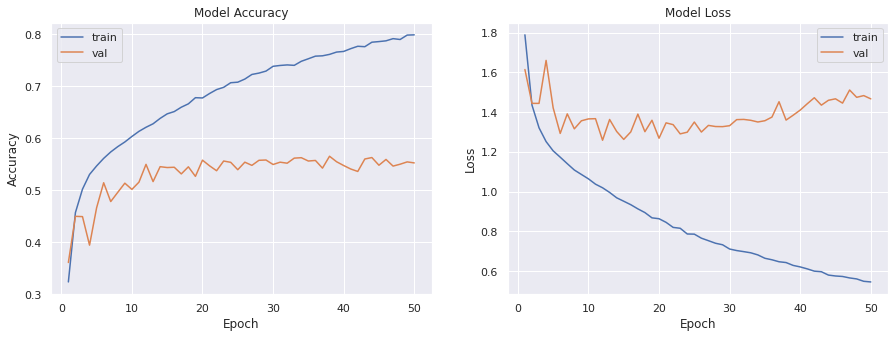

In [31]:
plot_model_history(history)